In [1]:
# following tutorial from https://www.kallistobus.tools/tutorials/kb_getting_started/python/kb_intro_2_python/

# Citation
Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285

Wolf, F. A., Angere, P. and Theis, F.J. SCANPY: large-scale single-cell gene expression data analysis. Genome Biology (2018). doi:10.1186/s13059-017-1382-0


In [1]:
!pip install --quiet matplotlib
!pip install --quiet scikit-learn
!pip install --quiet numpy
!pip install --quiet scipy

In [2]:
!pip install --quiet kb-python==0.24.1

In [10]:
# to install multicoreTSNE first downgrade cmake to 3.18.4

# pip uninstall cmake
# pip install cmake==3.18.4
!pip install --quiet scanpy python-igraph louvain MulticoreTSNE pybiomart


In [11]:
# import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

In [12]:
# download the data
!wget -q https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt -O checksums.txt
!wget -q https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz -O SRR8599150_S1_L001_R1_001.fastq.gz
!wget -q https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz -O SRR8599150_S1_L001_R2_001.fastq.gz

In [15]:
# This downloads a pre-built index for kallisto to use when pseudoaligning the reads
!kb ref -d mouse -i index.idx -g t2g.txt

[2022-11-13 16:40:56,820]    INFO Downloading files for mouse from https://caltech.box.com/shared/static/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz to tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
[2022-11-13 16:47:24,861]    INFO Extracting files from tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz


In [16]:
# This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
!kb count -i index.idx -g t2g.txt -x 10xv2 --h5ad -t 2 \
SRR8599150_S1_L001_R1_001.fastq.gz SRR8599150_S1_L001_R2_001.fastq.gz

[2022-11-13 16:50:33,068]    INFO Generating BUS file from
[2022-11-13 16:50:33,068]    INFO         SRR8599150_S1_L001_R1_001.fastq.gz
[2022-11-13 16:50:33,068]    INFO         SRR8599150_S1_L001_R2_001.fastq.gz
[2022-11-13 16:52:32,391]    INFO Sorting BUS file ./output.bus to tmp/output.s.bus
[2022-11-13 16:52:34,828]    INFO Whitelist not provided
[2022-11-13 16:52:34,829]    INFO Copying pre-packaged 10XV2 whitelist to .
[2022-11-13 16:52:34,873]    INFO Inspecting BUS file tmp/output.s.bus
[2022-11-13 16:52:36,864]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist ./10xv2_whitelist.txt
[2022-11-13 16:53:00,240]    INFO Sorting BUS file tmp/output.s.c.bus to ./output.unfiltered.bus
[2022-11-13 16:53:02,144]    INFO Generating count matrix ./counts_unfiltered/cells_x_genes from BUS file ./output.unfiltered.bus
[2022-11-13 16:53:05,343]    INFO Converting matrix ./counts_unfiltered/cells_x_genes.mtx to h5ad ./counts_unfiltered/adata.h5ad
/Users/

In [21]:
adata = anndata.read('counts_unfiltered/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 96775 × 55421

## Data contains 96775 cells (rows) and 55421 genes (columns)

In [53]:
# Short refresher video on PCA 
# https://www.youtube.com/watch?v=HMOI_lkzW08&ab_channel=StatQuestwithJoshStarmer

tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

print("shape of X", X.shape)


shape of X (96775, 2)


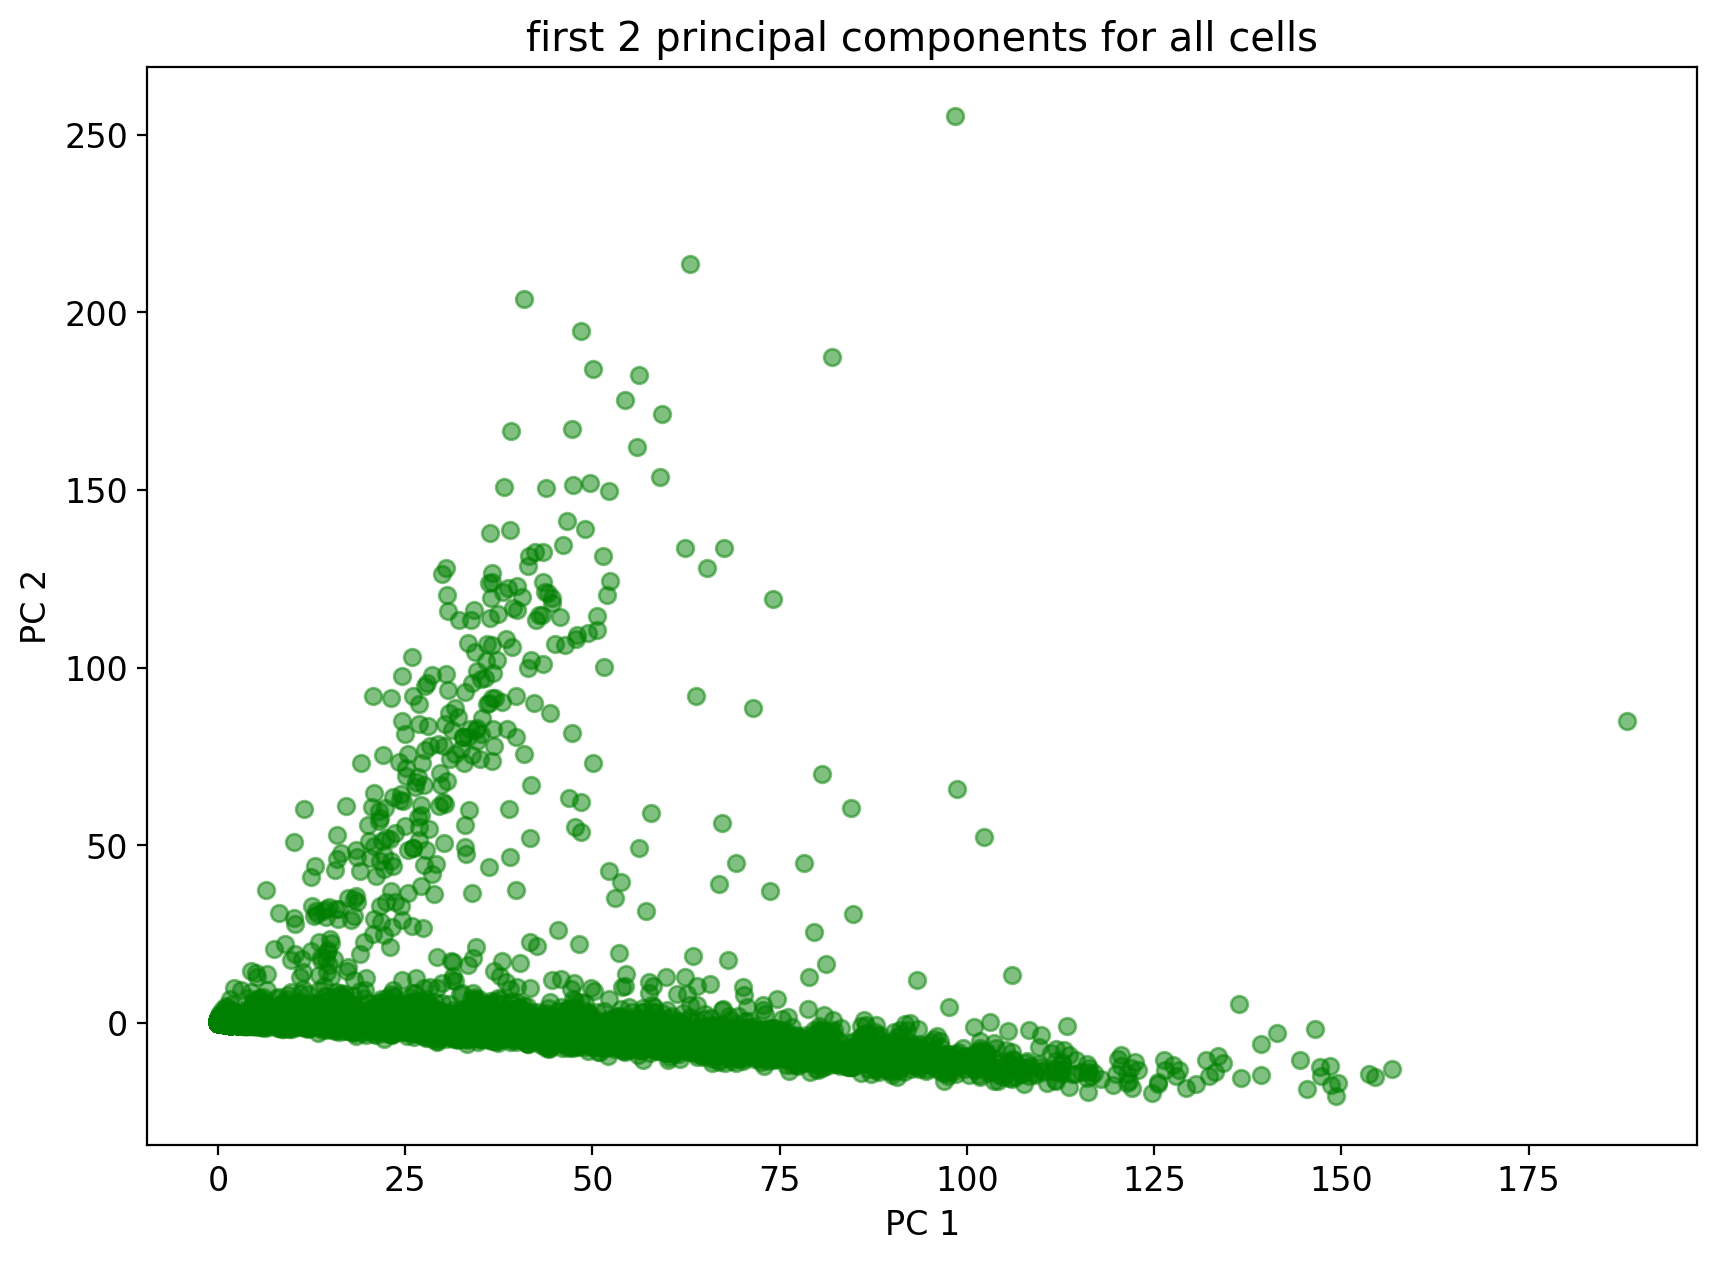

In [54]:
# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.title("first 2 principal components for all cells")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

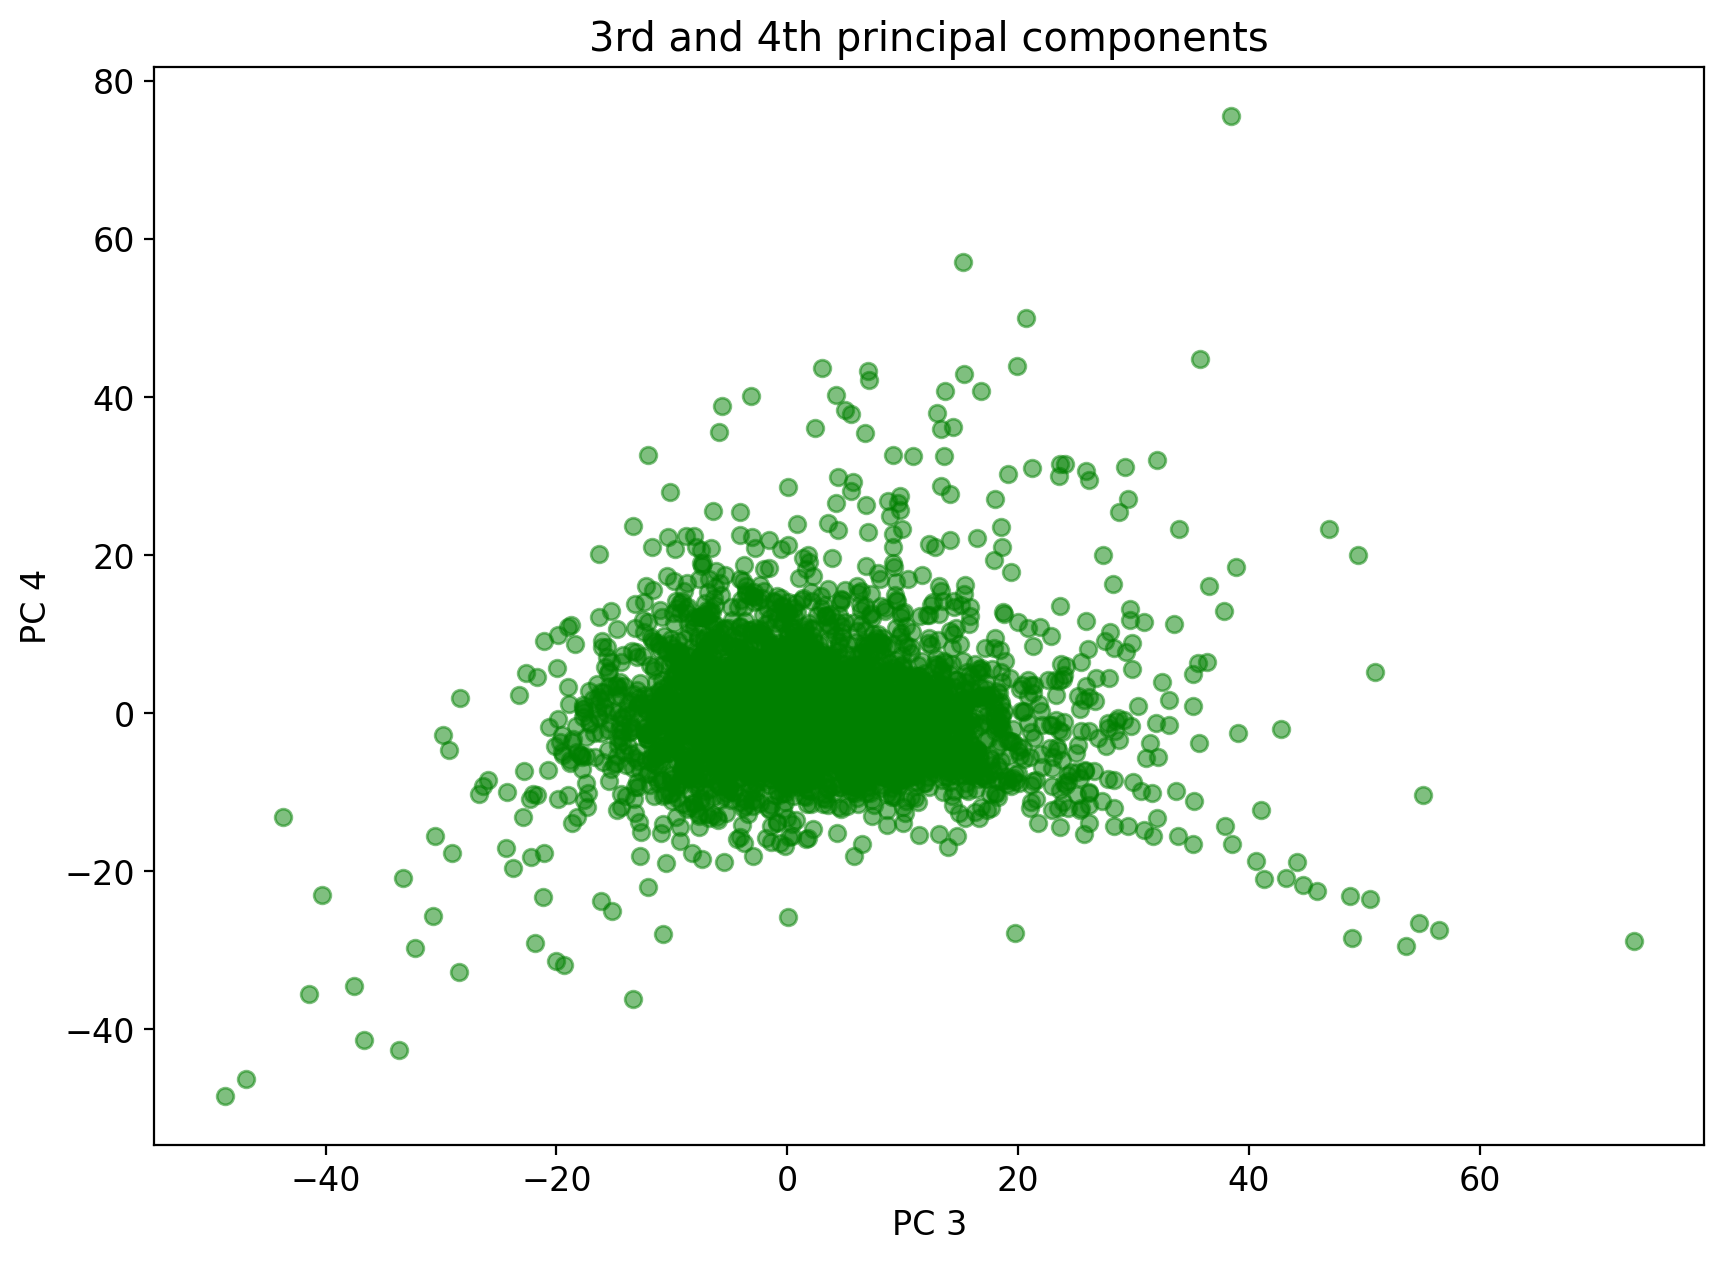

In [55]:
tsvd34 = TruncatedSVD(n_components=4)
tsvd34.fit(adata.X)
X34 = tsvd34.transform(adata.X)

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X34[:,2], X34[:,3], alpha=0.5, c="green")

plt.xlabel('PC 3')
plt.ylabel('PC 4')
plt.title("3rd and 4th principal components")
# plt.axis('off')
plt.show()

## Test for library saturation¶
For each cell we ask how many genes did we detect (or see non-zero expression). The idea is that if we have "saturated" our sequencing library then increasing the number of UMI counts (x-axis) will not yield an appreciable increase in the number of genes detected (y-axis).

In [62]:
print(adata.X.sum(axis=1).shape)
# adata.X.sum(axis=1) counts how many genes are expressed in each cell

print(np.sum(adata.X>0, axis=1).shape)

(96775, 1)
(96775, 1)


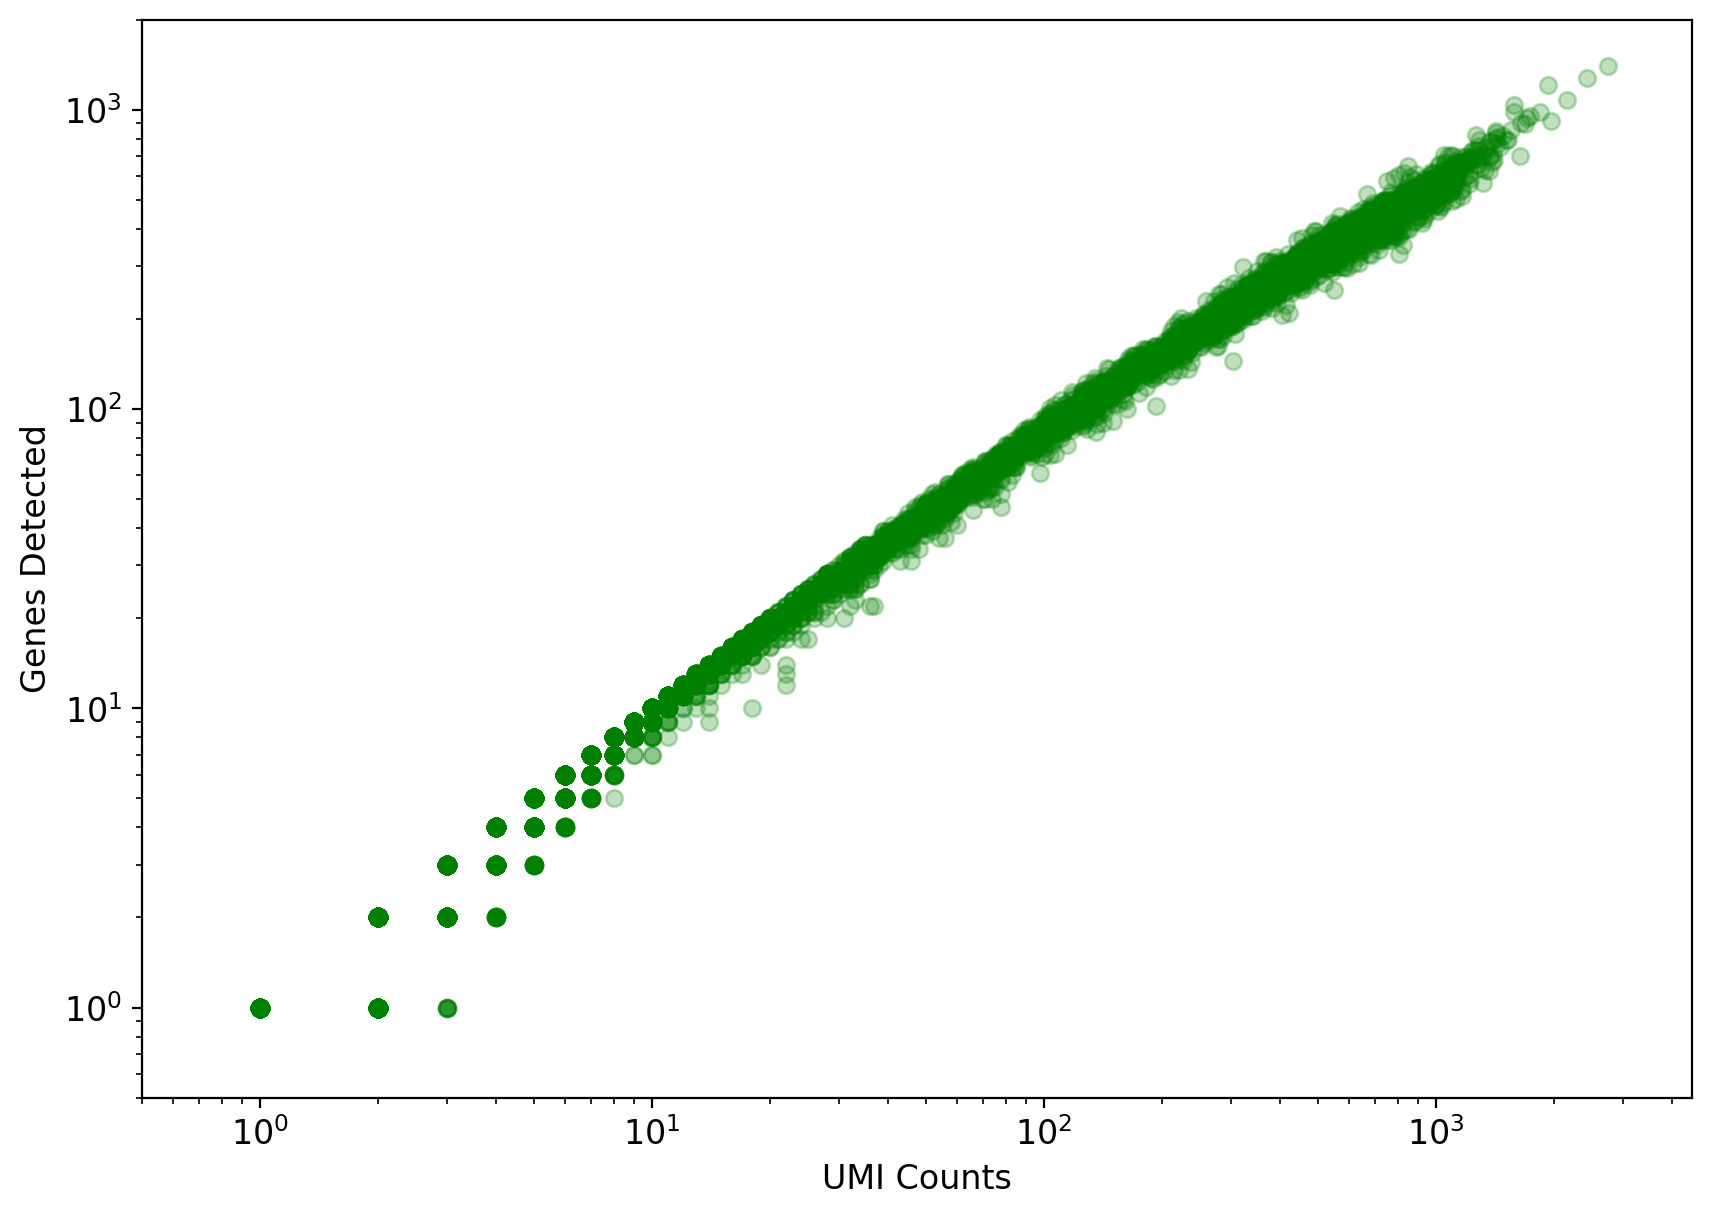

In [39]:

# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0] # the counts of how many genes are expressed in each cell
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0] # the non-zero 

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()



The "knee plot" was introduced in the Drop-seq paper: - Macosko et al., Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets, 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the x-axis), and the fraction of droplets with at least that number of cells is shown on the y-axis. The idea is that "real" cells have a certain number of UMI counts and that a threshold on the UMI counts filters those cells.

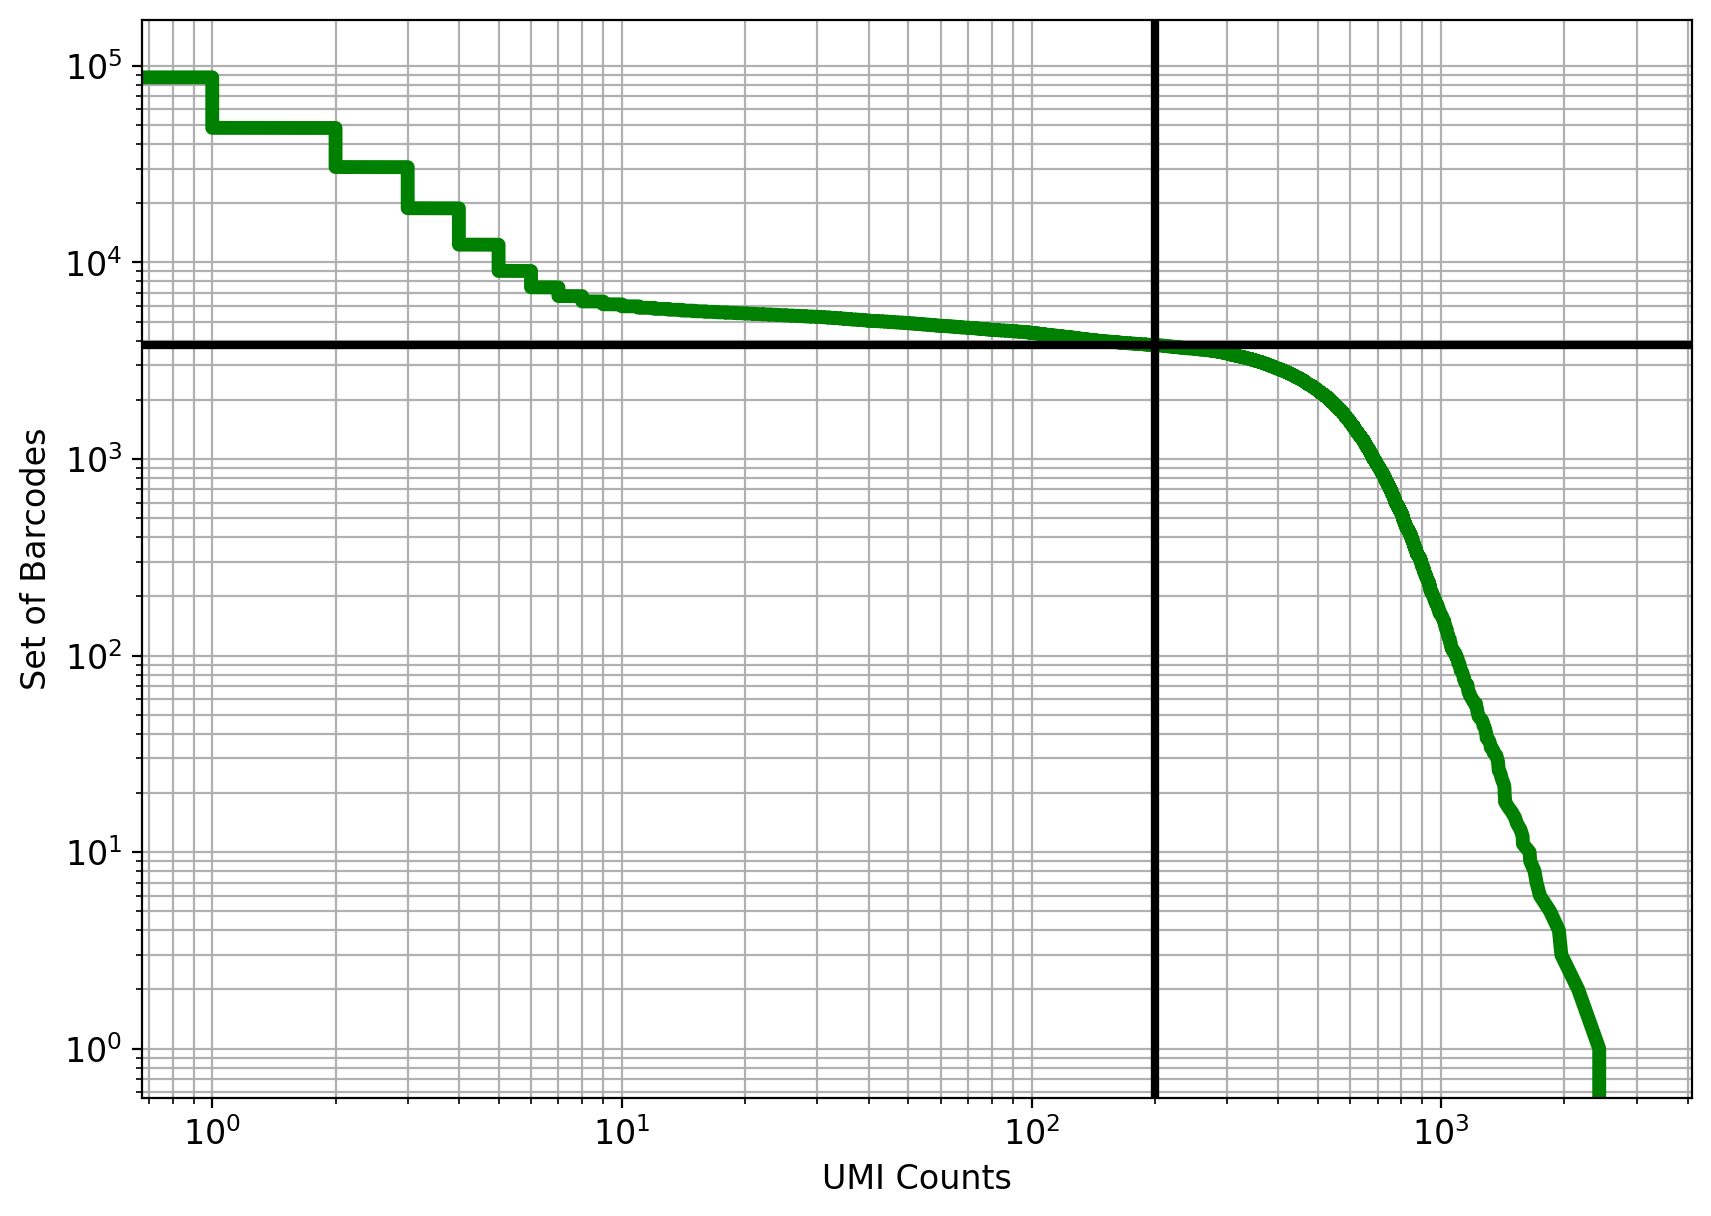

In [40]:

#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff =  200#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [63]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

3,791 cells passed the 200 UMI threshold


# Filter empty droplets

In [64]:
adata

AnnData object with n_obs × n_vars = 96775 × 55421

In [68]:
# Filter the cells according to the threshold determined from the knee plot
expected_num_cells = 200
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=knee[expected_num_cells])

In [69]:
adata

AnnData object with n_obs × n_vars = 201 × 55421
    obs: 'n_genes', 'n_counts'

## Filtering out by mitochondrial content

In [70]:
mito_ensembl_ids = sc.queries.mitochondrial_genes("mmusculus", attrname="ensembl_gene_id")

In [71]:
mito_genes = mito_ensembl_ids["ensembl_gene_id"].values
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

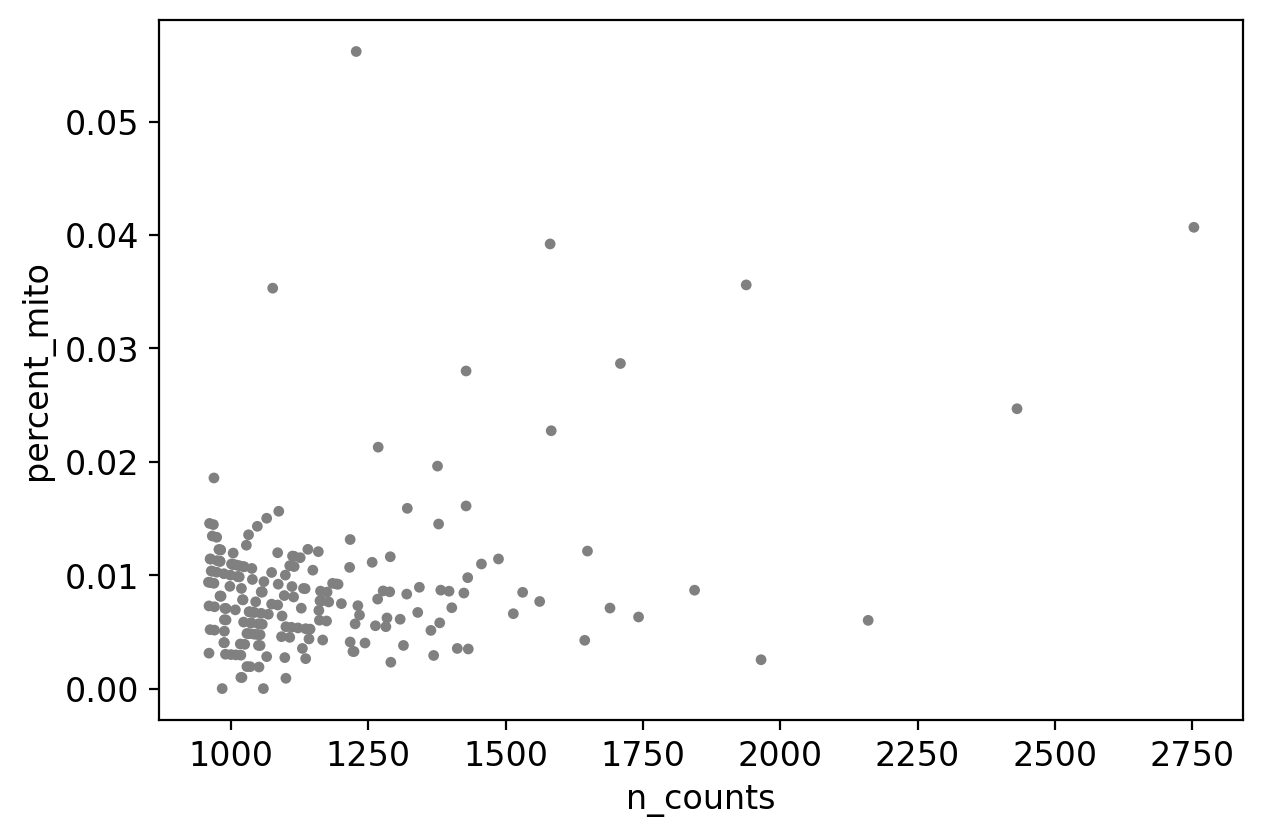

In [80]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', size=60)

## Visualizing count distributions
Examination of the gene count and UMI count distributions is useful QC to evaluate the quality of the library and how deeply it was sequenced.




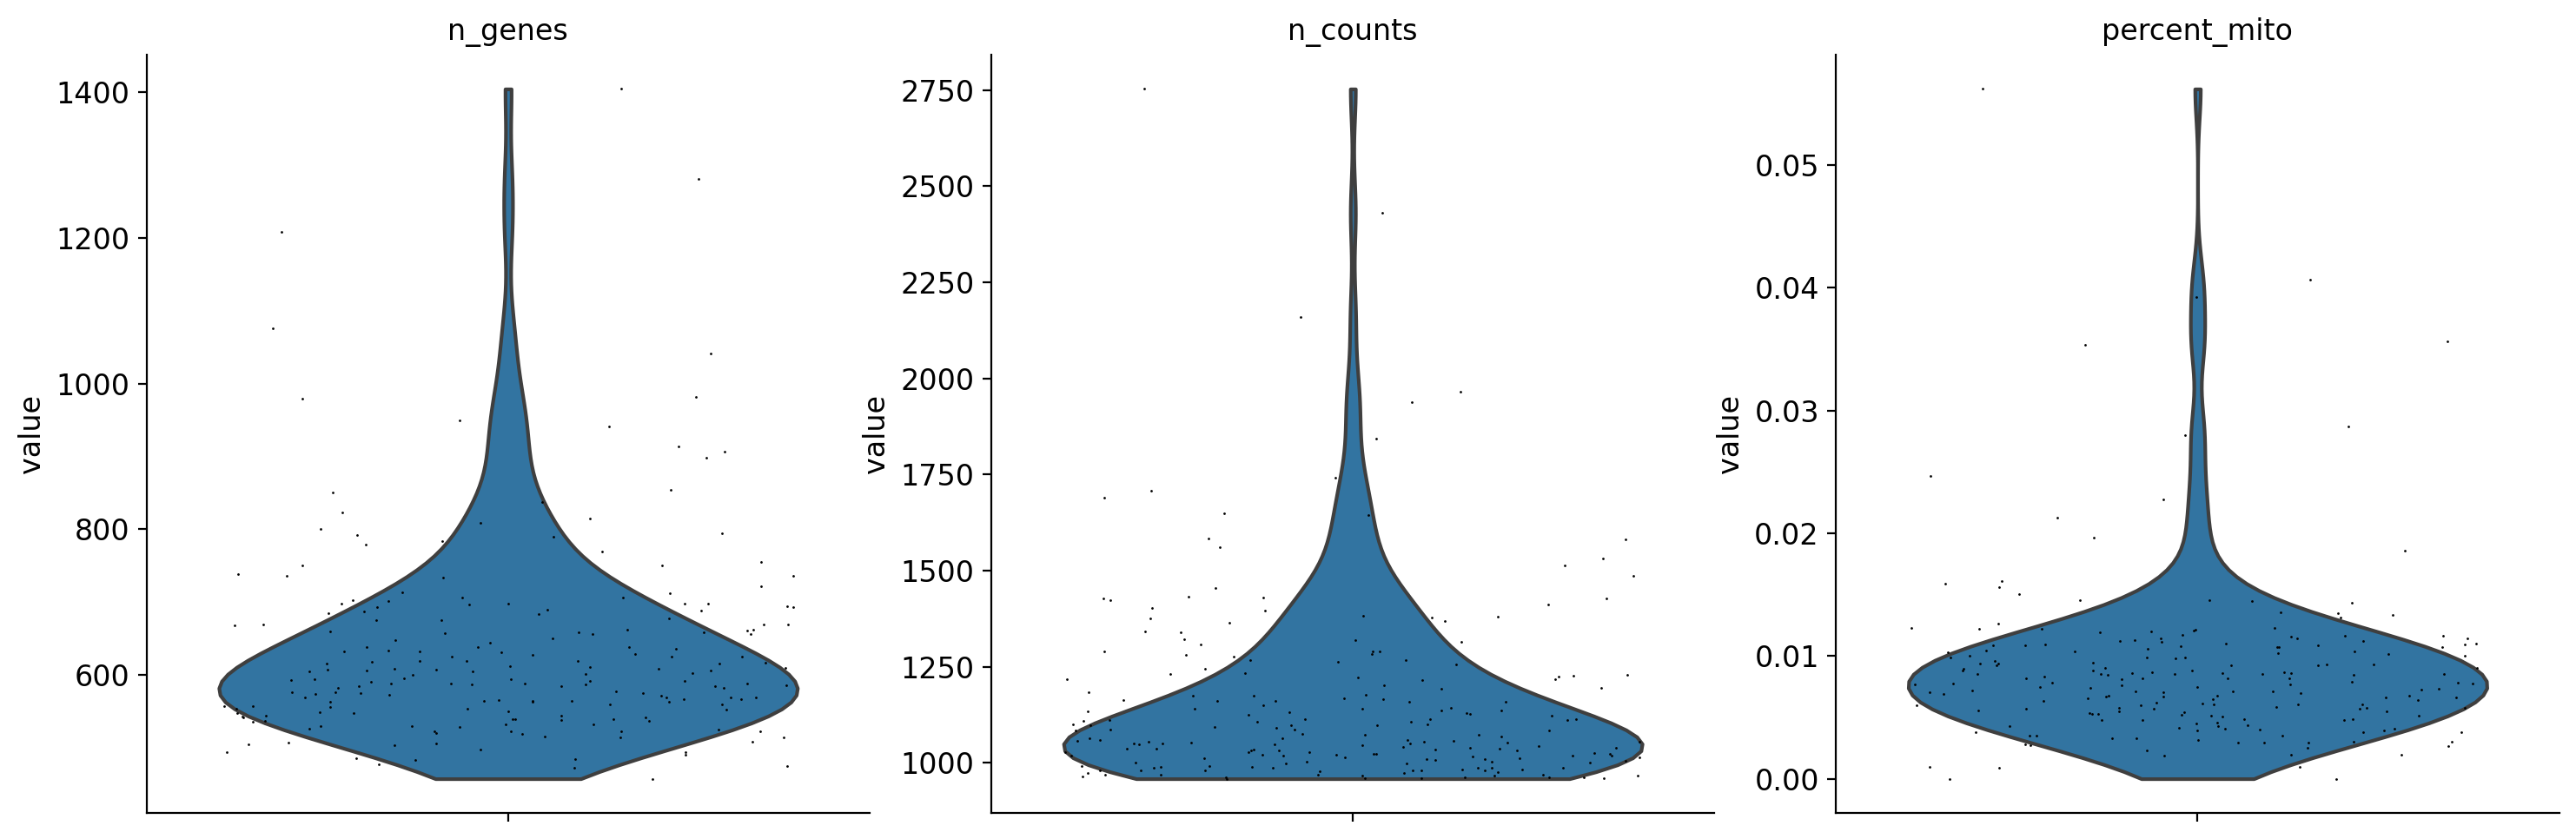

In [81]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
